In [1]:
import torch
import torch.cuda
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import requests, tarfile
from tqdm import tqdm

seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using {'cuda' if torch.cuda.is_available() else 'cpu'}")

Using cuda


In [3]:
dataPath = 'UTKFace'
if (dataPath not in os.listdir()):
    print("Downloading UTKFace...")
    url = "https://drive.google.com/uc?export=download&id=0BxYys69jI14kYVM3aVhKS1VhRUk&confirm=t&uuid=f981ca1d-ba0f-40c9-a4a0-8eaa887f3b6d&at=ANzk5s7e36SgjT0FlqBbRiijefRg:1681897584880"

    response = requests.get(url, stream=True)
    file = tarfile.open(fileobj=response.raw, mode="r|gz")
    file.extractall(path=".")
    print("Download complete.")
else:
    print("UTKFace already downloaded.")

Download complete.


In [4]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, dataPath, transform=None):
        self.dataPath = dataPath
        self.transform = transform
        self.imagePaths = [f for f in os.listdir(self.dataPath) if f.endswith('.jpg')]
        # self.imagePaths = [f for f in os.listdir(self.dataPath) if f.endswith('.jpg') and f.split('_')[2] != '4']
        
    def __getitem__(self, index):
        imagePath = self.imagePaths[index]
        try:
            imageTensor = torchvision.io.read_image(f'{self.dataPath}/{imagePath}').float()
            fileName = imagePath.split('_')
            label = torch.Tensor([int(fileName[0]), int(fileName[1]), int(fileName[2])])
            if self.transform:
                imageTensor = self.transform(imageTensor)
            return imageTensor, label
        except:
            return self.__getitem__((index + 1) % len(self.imagePaths))
        
    def __len__(self):
        return len(self.imagePaths)

In [5]:
# Resize and normalizde
transform = transforms.Compose(
    [transforms.Resize(224, antialias=True),
     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

dataset = MyDataset(dataPath, transform=transform)

batchSize = 100
testSplit = 0.1 # use 10% of dataset as test
validSplit = 0.2 / (1-testSplit) # use 20% of dataset as validation

testSize = int(np.floor(len(dataset)*testSplit))
trainValidSize = len(dataset) - testSize
validSize = int(np.ceil(trainValidSize*validSplit))
trainSize = trainValidSize - validSize
print(len(dataset), trainSize, validSize, testSize)

trainValidSet, testSet = torch.utils.data.random_split(dataset, [trainValidSize, testSize])
trainSet, validSet = torch.utils.data.random_split(trainValidSet, [trainSize, validSize])

trainLoader = torch.utils.data.DataLoader(trainSet, batch_size=batchSize, shuffle=True)
validLoader = torch.utils.data.DataLoader(validSet, batch_size=batchSize, shuffle=True)
testLoader = torch.utils.data.DataLoader(testSet, batch_size=batchSize, shuffle=False)

23708 16596 4742 2370


In [6]:
class ResNetModel(nn.Module):
    def __init__(self):
        super(ResNetModel,self).__init__()
        self.resnet = torchvision.models.resnet34(pretrained=True)
        for param in self.resnet.parameters():
            param.requires_grad=False
        self.resnet.fc = nn.Linear(512, 512)
        self.ageHidden = nn.Linear(512,512)
        # self.ageHidden2 = nn.Linear(512,256)
        self.ageDrop = nn.Dropout(p = 0.9)
        self.ageFc = nn.Linear(512,1)
        # self.genderHidden = nn.Linear(512,512)
        self.genderFc = nn.Linear(512,2)
        # self.ethnicityHidden = nn.Linear(512,512)
        self.ethnicityFc = nn.Linear(512,5)
        # self.ethnicityFc = nn.Linear(512,4)
    
    def forward(self, x):
        resOut = F.relu(self.resnet.forward(x))
        ageX = F.relu(self.ageHidden(resOut))
        ageOut = self.ageFc(self.ageDrop(ageX))
        # genderX = F.relu(self.genderHidden(resOut))
        genderOut = F.sigmoid(self.genderFc(resOut))
        # ethnicityX = F.relu(self.ethnicityHidden(resOut))
        ethnicityOut = self.ethnicityFc(resOut)
        return ageOut, genderOut, ethnicityOut

    def unfreeze(self):
        for param in self.resnet.parameters():
            param.requires_grad=True

In [7]:
# ResNetModel()

In [8]:
def lossAge(predictAge, targetAge):
    # loss = torch.sqrt(F.mse_loss(predictAge, targetAge))
    # return loss

    # age ranges weights
    # age_ranges = [(0, 1), (2, 23), (24, 25), (26, 26), (27, 35), (36, 150)]
    # age_weights = [0.4, 1, 0.6, 0.2, 0.6, 1.5]

    age_ranges = [(0, 15), (16, 30), (31, 45), (46, 60), (61, 150)]
    age_weights = [1, 0.5, 0.7, 1, 2]

    # weighted age loss
    loss_weights = torch.zeros_like(targetAge, dtype=torch.float32)
    for i, (start, end) in enumerate(age_ranges):
        mask = (targetAge >= start) & (targetAge <= end)
        loss_weights[mask] = age_weights[i]
    loss = torch.sqrt(F.mse_loss(predictAge, targetAge, reduction='none'))
    weighted_loss = loss * loss_weights
    return torch.mean(weighted_loss)

def lossGender(predictGender, targetGender):
    # classWeights = torch.tensor([0.95, 1.06], dtype=torch.float32).to(device)
    classWeights = torch.tensor([1, 1], dtype=torch.float32).to(device)
    loss = F.binary_cross_entropy(predictGender, targetGender, weight=classWeights)
    return loss

def lossEthnicity(predictEthnicity, targetEthnicity):
    classWeights = torch.tensor([0.47, 1.38, 1.04, 1.19, 2.82], dtype=torch.float32).to(device)
    #classWeights = torch.tensor([0.55, 1.60, 1.21, 1.38], dtype=torch.float32).to(device)
    # classWeights = torch.tensor([0.55, 1.60, 1.21, 1.38], dtype=torch.float32).to(device)
    loss = F.cross_entropy(predictEthnicity, targetEthnicity, weight=classWeights)

    return loss

def lossFunction(predictAge, predictGender, predictEthnicity, targetAge, targetGender, targetEthnicity):
    alpha = 1/6 # weight for age prediction
    beta = 7/8 # weight for gender prediction
    gamma = 1 # weight for ethncity prediction
    ageLoss = lossAge(predictAge, targetAge)
    genderLoss = lossGender(predictGender, targetGender)
    ethnicityLoss = lossEthnicity(predictEthnicity, targetEthnicity)
    totalLoss = alpha * ageLoss + beta * genderLoss + gamma * ethnicityLoss
    return totalLoss, ageLoss, genderLoss, ethnicityLoss

In [9]:
def trainNetwork(model, optimizer, lossFunction, trainLoader, validLoader, epochs, unfreezeEpoch, device, modelPath):
    model.train()
    trainLoaderSize = len(trainLoader)
    validLoaderSize = len(validLoader)
    trainAgeLoss, trainGenderLoss, trainEthnicityLoss, trainTotalLoss = [], [], [], []
    validAgeLoss, validGenderLoss, validEthnicityLoss, validTotalLoss = [], [], [], []
    trainAge3Accuracy, trainAge5Accuracy, trainGenderAccuracy, trainEthnicityAccuracy = [], [], [], []
    validAge3Accuracy, validAge5Accuracy, validGenderAccuracy, validEthnicityAccuracy = [], [], [], []

    for epoch in tqdm(range(1, epochs + 1)):
        if epoch == unfreezeEpoch:
            model.unfreeze()
            print("\tUnfreeze the model for fine tuning")
        
        ### TRAINING ###
        trainAgeLoss.append(0)
        trainGenderLoss.append(0)
        trainEthnicityLoss.append(0)
        trainTotalLoss.append(0)
        trainAge3Accuracy.append(0)
        trainAge5Accuracy.append(0)
        trainGenderAccuracy.append(0)
        trainEthnicityAccuracy.append(0)

        for batch_nr, (images, labels) in enumerate(trainLoader):
            # Move data to GPU (if exists)
            images, labels = images.to(device), labels.long().to(device) 

            ageLabels = labels[:, 0]
            genderLabels = labels[:, 1]
            #ethnicityLabels = F.one_hot(labels[:, 2], num_classes=5).float()
            ethnicityLabels = labels[:, 2]

            # Predict
            agePredictions, genderPredictions, ethnicityPredictions = model(images)

            # Get loss and backpropogate
            totalLoss, ageLoss, genderLoss, ethnicityLoss = lossFunction(agePredictions, genderPredictions, ethnicityPredictions, 
                                                            ageLabels.view(-1, 1).float(), F.one_hot(genderLabels, num_classes=2).float(), F.one_hot(ethnicityLabels, num_classes=5).float())
            
            totalLoss.backward()

            # Optimize parameters (weights and biases) and remove gradients after
            optimizer.step() 
            optimizer.zero_grad()

            # Save loss for whole epoch
            trainAgeLoss[-1] += ageLoss.item() / trainLoaderSize
            trainGenderLoss[-1] += genderLoss.item() / trainLoaderSize
            trainEthnicityLoss[-1] += ethnicityLoss.item() / trainLoaderSize
            trainTotalLoss[-1] += totalLoss.item() / trainLoaderSize

            # Calcualte accuracy
            totalTrain = len(images) * trainLoaderSize
            
            agePredictions = torch.round(agePredictions).view(1, -1)
            trainAge3Accuracy[-1] += ((agePredictions - ageLabels).abs() <= 3).sum().item() * 100 / totalTrain
            trainAge5Accuracy[-1] += ((agePredictions - ageLabels).abs() <= 5).sum().item() * 100 / totalTrain

            _, genderPredictions = torch.max(genderPredictions, 1) 
            trainGenderAccuracy[-1] += (genderPredictions == genderLabels).sum().item() * 100 / totalTrain

            _, ethnicityPredictions = torch.max(ethnicityPredictions, 1) 
            trainEthnicityAccuracy[-1] += (ethnicityPredictions == ethnicityLabels).sum().item() * 100 / totalTrain

        ### VALIDATION ###
        validAgeLoss.append(0)
        validGenderLoss.append(0)
        validEthnicityLoss.append(0)
        validTotalLoss.append(0)
        validAge3Accuracy.append(0)
        validAge5Accuracy.append(0)
        validGenderAccuracy.append(0)
        validEthnicityAccuracy.append(0)

        for batch_nr, (images, labels) in enumerate(validLoader):
            # Move data to GPU (if exists)
            images, labels = images.to(device), labels.long().to(device) 

            ageLabels = labels[:, 0]
            genderLabels = labels[:, 1]
            #ethnicityLabels = F.one_hot(labels[:, 2], num_classes=5).float()
            ethnicityLabels = labels[:, 2]

            # Predict            
            agePredictions, genderPredictions, ethnicityPredictions = model(images)

            # Get loss
            totalLoss, ageLoss, genderLoss, ethnicityLoss = lossFunction(agePredictions, genderPredictions, ethnicityPredictions, 
                                                            ageLabels.view(-1, 1).float(), F.one_hot(genderLabels, num_classes=2).float(), F.one_hot(ethnicityLabels, num_classes=5).float())
            
            # Save loss for whole epoch
            validAgeLoss[-1] += ageLoss.item() / validLoaderSize
            validGenderLoss[-1] += genderLoss.item() / validLoaderSize
            validEthnicityLoss[-1] += ethnicityLoss.item() / validLoaderSize
            validTotalLoss[-1] += totalLoss.item() / validLoaderSize

            # Calcualte accuracy
            totalValid = len(images) * validLoaderSize

            agePredictions = torch.round(agePredictions).view(1, -1)
            validAge3Accuracy[-1] += ((agePredictions - ageLabels).abs() <= 3).sum().item() * 100 / totalValid
            validAge5Accuracy[-1] += ((agePredictions - ageLabels).abs() <= 5).sum().item() * 100 / totalValid
            
            _, genderPredictions = torch.max(genderPredictions, 1) 
            validGenderAccuracy[-1] += (genderPredictions == genderLabels).sum().item() * 100 / totalValid

            _, ethnicityPredictions = torch.max(ethnicityPredictions, 1) 
            validEthnicityAccuracy[-1] += (ethnicityPredictions == ethnicityLabels).sum().item() * 100 / totalValid


        # Print reuslt of epoch
        print(f'\n\tTraining Losses:     (Age: {trainAgeLoss[-1]:.3f}, Gender: {trainGenderLoss[-1]:.3f}, Ethnicity: {trainEthnicityLoss[-1]:.3f}, Total: {trainTotalLoss[-1]:.3f})\t'
              f'\n\tValidation Losses:   (Age: {validAgeLoss[-1]:.3f}, Gender: {validGenderLoss[-1]:.3f}, Ethnicity: {validEthnicityLoss[-1]:.3f}, Total: {validTotalLoss[-1]:.3f})\t'
              f'\n\tTraining Accuracy:   (Age+/-3: {trainAge3Accuracy[-1]:.2f}%, Age+/-5: {trainAge5Accuracy[-1]:.2f}%, Gender: {trainGenderAccuracy[-1]:.2f}%, Ethnicity: {trainEthnicityAccuracy[-1]:.2f}%)\t'
              f'\n\tValidation Accuracy: (Age+/-3: {validAge3Accuracy[-1]:.2f}%, Age+/-5: {validAge5Accuracy[-1]:.2f}%, Gender: {validGenderAccuracy[-1]:.2f}%, Ethnicity: {validEthnicityAccuracy[-1]:.2f}%)\t')
        
    torch.save(model, modelPath)
    print(f"Saved model to {modelPath}")
    losses = [trainAgeLoss, trainGenderLoss, trainEthnicityLoss, trainTotalLoss, validAgeLoss, validGenderLoss, validEthnicityLoss, validTotalLoss]
    accuracy = [trainAge3Accuracy, trainAge5Accuracy, trainGenderAccuracy, trainEthnicityAccuracy, validAge3Accuracy, validAge5Accuracy, validGenderAccuracy, validEthnicityAccuracy]
    return losses, accuracy

In [10]:
resnetModel = ResNetModel().to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 154MB/s]


In [11]:
epochs = 24
unfreezeEpoch = 3
learningRate = 3e-3
modelPath = "resnet.pth"

optimizer = torch.optim.SGD(resnetModel.parameters(), lr=learningRate, weight_decay=0.05)

losses, accuracy = trainNetwork(resnetModel, optimizer, lossFunction, trainLoader, validLoader, epochs, unfreezeEpoch, device, modelPath)

  4%|▍         | 1/24 [01:25<32:40, 85.24s/it]


	Training Losses:     (Age: 32.253, Gender: 0.676, Ethnicity: 1.578, Total: 7.545)	
	Validation Losses:   (Age: 29.906, Gender: 0.653, Ethnicity: 1.558, Total: 7.113)	
	Training Accuracy:   (Age+/-3: 9.21%, Age+/-5: 11.07%, Gender: 60.28%, Ethnicity: 26.36%)	
	Validation Accuracy: (Age+/-3: 8.06%, Age+/-5: 12.12%, Gender: 69.06%, Ethnicity: 30.11%)	


  8%|▊         | 2/24 [02:39<28:59, 79.05s/it]


	Training Losses:     (Age: 23.947, Gender: 0.636, Ethnicity: 1.486, Total: 6.034)	
	Validation Losses:   (Age: 19.159, Gender: 0.614, Ethnicity: 1.481, Total: 5.211)	
	Training Accuracy:   (Age+/-3: 9.97%, Age+/-5: 15.56%, Gender: 70.11%, Ethnicity: 39.57%)	
	Validation Accuracy: (Age+/-3: 14.68%, Age+/-5: 22.11%, Gender: 69.61%, Ethnicity: 37.43%)	
	Unfreeze the model for fine tuning


 12%|█▎        | 3/24 [04:45<35:10, 100.49s/it]


	Training Losses:     (Age: 12.835, Gender: 0.575, Ethnicity: 1.355, Total: 3.997)	
	Validation Losses:   (Age: 10.529, Gender: 0.531, Ethnicity: 1.314, Total: 3.534)	
	Training Accuracy:   (Age+/-3: 18.22%, Age+/-5: 29.31%, Gender: 74.73%, Ethnicity: 52.87%)	
	Validation Accuracy: (Age+/-3: 22.68%, Age+/-5: 34.95%, Gender: 76.96%, Ethnicity: 60.41%)	


 17%|█▋        | 4/24 [06:51<36:46, 110.32s/it]


	Training Losses:     (Age: 9.953, Gender: 0.490, Ethnicity: 1.180, Total: 3.267)	
	Validation Losses:   (Age: 9.576, Gender: 0.439, Ethnicity: 1.156, Total: 3.137)	
	Training Accuracy:   (Age+/-3: 25.21%, Age+/-5: 38.17%, Gender: 78.92%, Ethnicity: 59.34%)	
	Validation Accuracy: (Age+/-3: 28.03%, Age+/-5: 39.59%, Gender: 80.72%, Ethnicity: 55.55%)	


 21%|██        | 5/24 [08:56<36:39, 115.74s/it]


	Training Losses:     (Age: 8.957, Gender: 0.403, Ethnicity: 1.029, Total: 2.875)	
	Validation Losses:   (Age: 9.062, Gender: 0.367, Ethnicity: 1.045, Total: 2.876)	
	Training Accuracy:   (Age+/-3: 28.67%, Age+/-5: 41.63%, Gender: 82.79%, Ethnicity: 64.44%)	
	Validation Accuracy: (Age+/-3: 30.20%, Age+/-5: 42.45%, Gender: 83.90%, Ethnicity: 64.22%)	


 25%|██▌       | 6/24 [11:02<35:43, 119.10s/it]


	Training Losses:     (Age: 8.425, Gender: 0.342, Ethnicity: 0.916, Total: 2.619)	
	Validation Losses:   (Age: 8.638, Gender: 0.323, Ethnicity: 0.960, Total: 2.682)	
	Training Accuracy:   (Age+/-3: 31.37%, Age+/-5: 44.25%, Gender: 85.06%, Ethnicity: 68.49%)	
	Validation Accuracy: (Age+/-3: 31.24%, Age+/-5: 44.48%, Gender: 85.92%, Ethnicity: 66.99%)	


 29%|██▉       | 7/24 [13:07<34:19, 121.16s/it]


	Training Losses:     (Age: 8.081, Gender: 0.300, Ethnicity: 0.829, Total: 2.438)	
	Validation Losses:   (Age: 8.331, Gender: 0.292, Ethnicity: 0.903, Total: 2.547)	
	Training Accuracy:   (Age+/-3: 32.54%, Age+/-5: 45.72%, Gender: 86.99%, Ethnicity: 71.77%)	
	Validation Accuracy: (Age+/-3: 32.59%, Age+/-5: 46.00%, Gender: 86.79%, Ethnicity: 69.93%)	


 33%|███▎      | 8/24 [15:12<32:37, 122.31s/it]


	Training Losses:     (Age: 7.736, Gender: 0.269, Ethnicity: 0.748, Total: 2.273)	
	Validation Losses:   (Age: 8.172, Gender: 0.266, Ethnicity: 0.866, Total: 2.461)	
	Training Accuracy:   (Age+/-3: 34.10%, Age+/-5: 47.09%, Gender: 88.47%, Ethnicity: 74.59%)	
	Validation Accuracy: (Age+/-3: 31.79%, Age+/-5: 45.16%, Gender: 88.30%, Ethnicity: 73.30%)	


 38%|███▊      | 9/24 [17:17<30:47, 123.13s/it]


	Training Losses:     (Age: 7.489, Gender: 0.249, Ethnicity: 0.690, Total: 2.156)	
	Validation Losses:   (Age: 8.029, Gender: 0.255, Ethnicity: 0.827, Total: 2.388)	
	Training Accuracy:   (Age+/-3: 34.95%, Age+/-5: 48.75%, Gender: 89.64%, Ethnicity: 76.70%)	
	Validation Accuracy: (Age+/-3: 33.20%, Age+/-5: 46.01%, Gender: 88.80%, Ethnicity: 71.95%)	


 42%|████▏     | 10/24 [19:22<28:52, 123.72s/it]


	Training Losses:     (Age: 7.370, Gender: 0.230, Ethnicity: 0.631, Total: 2.060)	
	Validation Losses:   (Age: 7.944, Gender: 0.245, Ethnicity: 0.807, Total: 2.345)	
	Training Accuracy:   (Age+/-3: 35.41%, Age+/-5: 49.32%, Gender: 90.54%, Ethnicity: 78.89%)	
	Validation Accuracy: (Age+/-3: 32.91%, Age+/-5: 46.60%, Gender: 89.22%, Ethnicity: 75.11%)	


 46%|████▌     | 11/24 [21:27<26:52, 124.05s/it]


	Training Losses:     (Age: 7.169, Gender: 0.215, Ethnicity: 0.575, Total: 1.958)	
	Validation Losses:   (Age: 7.998, Gender: 0.237, Ethnicity: 0.767, Total: 2.307)	
	Training Accuracy:   (Age+/-3: 36.48%, Age+/-5: 50.45%, Gender: 91.35%, Ethnicity: 80.84%)	
	Validation Accuracy: (Age+/-3: 34.34%, Age+/-5: 47.06%, Gender: 89.91%, Ethnicity: 75.84%)	


 50%|█████     | 12/24 [23:32<24:51, 124.33s/it]


	Training Losses:     (Age: 7.015, Gender: 0.203, Ethnicity: 0.521, Total: 1.868)	
	Validation Losses:   (Age: 8.135, Gender: 0.233, Ethnicity: 0.766, Total: 2.326)	
	Training Accuracy:   (Age+/-3: 36.34%, Age+/-5: 51.12%, Gender: 91.92%, Ethnicity: 82.39%)	
	Validation Accuracy: (Age+/-3: 33.03%, Age+/-5: 46.54%, Gender: 89.76%, Ethnicity: 76.41%)	


 54%|█████▍    | 13/24 [25:37<22:49, 124.53s/it]


	Training Losses:     (Age: 7.033, Gender: 0.195, Ethnicity: 0.472, Total: 1.814)	
	Validation Losses:   (Age: 7.999, Gender: 0.226, Ethnicity: 0.755, Total: 2.287)	
	Training Accuracy:   (Age+/-3: 36.70%, Age+/-5: 50.83%, Gender: 92.49%, Ethnicity: 84.40%)	
	Validation Accuracy: (Age+/-3: 34.30%, Age+/-5: 47.14%, Gender: 90.04%, Ethnicity: 75.34%)	


 58%|█████▊    | 14/24 [27:42<20:46, 124.63s/it]


	Training Losses:     (Age: 6.790, Gender: 0.186, Ethnicity: 0.419, Total: 1.713)	
	Validation Losses:   (Age: 7.702, Gender: 0.224, Ethnicity: 0.749, Total: 2.229)	
	Training Accuracy:   (Age+/-3: 37.48%, Age+/-5: 51.98%, Gender: 93.04%, Ethnicity: 86.09%)	
	Validation Accuracy: (Age+/-3: 33.78%, Age+/-5: 48.34%, Gender: 91.04%, Ethnicity: 77.98%)	


 62%|██████▎   | 15/24 [29:46<18:41, 124.60s/it]


	Training Losses:     (Age: 6.701, Gender: 0.178, Ethnicity: 0.369, Total: 1.641)	
	Validation Losses:   (Age: 7.970, Gender: 0.217, Ethnicity: 0.750, Total: 2.268)	
	Training Accuracy:   (Age+/-3: 37.74%, Age+/-5: 53.04%, Gender: 93.35%, Ethnicity: 88.26%)	
	Validation Accuracy: (Age+/-3: 33.63%, Age+/-5: 46.51%, Gender: 91.43%, Ethnicity: 77.02%)	


 67%|██████▋   | 16/24 [31:52<16:40, 125.04s/it]


	Training Losses:     (Age: 6.558, Gender: 0.168, Ethnicity: 0.326, Total: 1.566)	
	Validation Losses:   (Age: 7.698, Gender: 0.218, Ethnicity: 0.765, Total: 2.238)	
	Training Accuracy:   (Age+/-3: 38.74%, Age+/-5: 53.62%, Gender: 93.95%, Ethnicity: 89.34%)	
	Validation Accuracy: (Age+/-3: 33.42%, Age+/-5: 47.16%, Gender: 90.78%, Ethnicity: 78.32%)	


 71%|███████   | 17/24 [33:58<14:36, 125.28s/it]


	Training Losses:     (Age: 6.593, Gender: 0.159, Ethnicity: 0.277, Total: 1.516)	
	Validation Losses:   (Age: 7.779, Gender: 0.216, Ethnicity: 0.788, Total: 2.274)	
	Training Accuracy:   (Age+/-3: 38.81%, Age+/-5: 53.66%, Gender: 94.49%, Ethnicity: 91.04%)	
	Validation Accuracy: (Age+/-3: 34.67%, Age+/-5: 47.52%, Gender: 91.10%, Ethnicity: 78.24%)	


 75%|███████▌  | 18/24 [36:03<12:31, 125.27s/it]


	Training Losses:     (Age: 6.570, Gender: 0.151, Ethnicity: 0.243, Total: 1.471)	
	Validation Losses:   (Age: 7.636, Gender: 0.217, Ethnicity: 0.783, Total: 2.245)	
	Training Accuracy:   (Age+/-3: 39.02%, Age+/-5: 54.15%, Gender: 94.81%, Ethnicity: 92.42%)	
	Validation Accuracy: (Age+/-3: 34.57%, Age+/-5: 47.45%, Gender: 91.15%, Ethnicity: 78.31%)	


 79%|███████▉  | 19/24 [38:09<10:26, 125.30s/it]


	Training Losses:     (Age: 6.525, Gender: 0.146, Ethnicity: 0.200, Total: 1.416)	
	Validation Losses:   (Age: 7.446, Gender: 0.211, Ethnicity: 0.812, Total: 2.237)	
	Training Accuracy:   (Age+/-3: 39.49%, Age+/-5: 54.18%, Gender: 95.13%, Ethnicity: 93.86%)	
	Validation Accuracy: (Age+/-3: 35.54%, Age+/-5: 48.73%, Gender: 91.88%, Ethnicity: 79.32%)	


 83%|████████▎ | 20/24 [40:14<08:21, 125.39s/it]


	Training Losses:     (Age: 6.372, Gender: 0.140, Ethnicity: 0.175, Total: 1.360)	
	Validation Losses:   (Age: 7.468, Gender: 0.208, Ethnicity: 0.808, Total: 2.235)	
	Training Accuracy:   (Age+/-3: 40.23%, Age+/-5: 55.01%, Gender: 95.41%, Ethnicity: 94.64%)	
	Validation Accuracy: (Age+/-3: 34.66%, Age+/-5: 48.30%, Gender: 91.58%, Ethnicity: 79.08%)	


 88%|████████▊ | 21/24 [42:20<06:16, 125.47s/it]


	Training Losses:     (Age: 6.379, Gender: 0.134, Ethnicity: 0.152, Total: 1.333)	
	Validation Losses:   (Age: 7.673, Gender: 0.213, Ethnicity: 0.828, Total: 2.293)	
	Training Accuracy:   (Age+/-3: 40.01%, Age+/-5: 55.13%, Gender: 95.71%, Ethnicity: 95.75%)	
	Validation Accuracy: (Age+/-3: 34.51%, Age+/-5: 48.18%, Gender: 91.36%, Ethnicity: 79.66%)	


 92%|█████████▏| 22/24 [44:26<04:11, 125.64s/it]


	Training Losses:     (Age: 6.207, Gender: 0.127, Ethnicity: 0.134, Total: 1.280)	
	Validation Losses:   (Age: 7.578, Gender: 0.209, Ethnicity: 0.870, Total: 2.316)	
	Training Accuracy:   (Age+/-3: 40.84%, Age+/-5: 55.84%, Gender: 95.94%, Ethnicity: 96.34%)	
	Validation Accuracy: (Age+/-3: 35.13%, Age+/-5: 48.46%, Gender: 91.45%, Ethnicity: 79.78%)	


 96%|█████████▌| 23/24 [46:32<02:05, 125.64s/it]


	Training Losses:     (Age: 6.329, Gender: 0.121, Ethnicity: 0.119, Total: 1.280)	
	Validation Losses:   (Age: 7.618, Gender: 0.208, Ethnicity: 0.919, Total: 2.370)	
	Training Accuracy:   (Age+/-3: 40.28%, Age+/-5: 55.55%, Gender: 96.36%, Ethnicity: 96.99%)	
	Validation Accuracy: (Age+/-3: 34.95%, Age+/-5: 48.91%, Gender: 91.56%, Ethnicity: 79.89%)	


100%|██████████| 24/24 [48:37<00:00, 121.57s/it]


	Training Losses:     (Age: 6.272, Gender: 0.117, Ethnicity: 0.107, Total: 1.255)	
	Validation Losses:   (Age: 7.571, Gender: 0.210, Ethnicity: 0.915, Total: 2.361)	
	Training Accuracy:   (Age+/-3: 40.85%, Age+/-5: 56.19%, Gender: 96.41%, Ethnicity: 97.58%)	
	Validation Accuracy: (Age+/-3: 34.40%, Age+/-5: 48.19%, Gender: 91.50%, Ethnicity: 79.78%)	
Saved model to resnet.pth


In [12]:
import matplotlib.pyplot as plt

def plotLossesAccuracy(losses, accuracy):
    fig, axs = plt.subplots(2, 4, figsize=(12, 7))

    # age loss
    axs[0, 0].plot(losses[0], label='Train')
    axs[0, 0].plot(losses[4], label='Validation')
    axs[0, 0].set_title('Age Loss')
    axs[0, 0].legend()

    # gender loss
    axs[0, 1].plot(losses[1], label='Train')
    axs[0, 1].plot(losses[5], label='Validation')
    axs[0, 1].set_title('Gender Loss')
    axs[0, 1].legend()

    # ethnicity loss
    axs[0, 2].plot(losses[2], label='Train')
    axs[0, 2].plot(losses[6], label='Validation')
    axs[0, 2].set_title('Ethnicity Loss')
    axs[0, 2].legend()

    # total loss
    axs[0, 3].plot(losses[3], label='Train')
    axs[0, 3].plot(losses[7], label='Validation')
    axs[0, 3].set_title('Total Loss')
    axs[0, 3].legend()

    # age accuracies
    axs[1, 0].plot(accuracy[0], label='Train +/-3')
    axs[1, 0].plot(accuracy[4], label='Validation +/-3')
    axs[1, 0].plot(accuracy[1], '--', label='Train +/-5')
    axs[1, 0].plot(accuracy[5], '--', label='Validation +/-5')
    axs[1, 0].set_title('Age Accuracy')
    axs[1, 0].legend()

    # gender accuracy
    axs[1, 1].plot(accuracy[2], label='Train')
    axs[1, 1].plot(accuracy[6], label='Validation')
    axs[1, 1].set_title('Gender Accuracy')
    axs[1, 1].legend()

    # ethnicity accuracy
    axs[1, 2].plot(accuracy[3], label='Train')
    axs[1, 2].plot(accuracy[7], label='Validation')
    axs[1, 2].set_title('Ethnicity Accuracy')
    axs[1, 2].legend()

    axs[1, 3].set_visible(False)

    # title and adjust the spacing
    fig.suptitle('Losses and Accuracy')
    fig.tight_layout()

    plt.show()

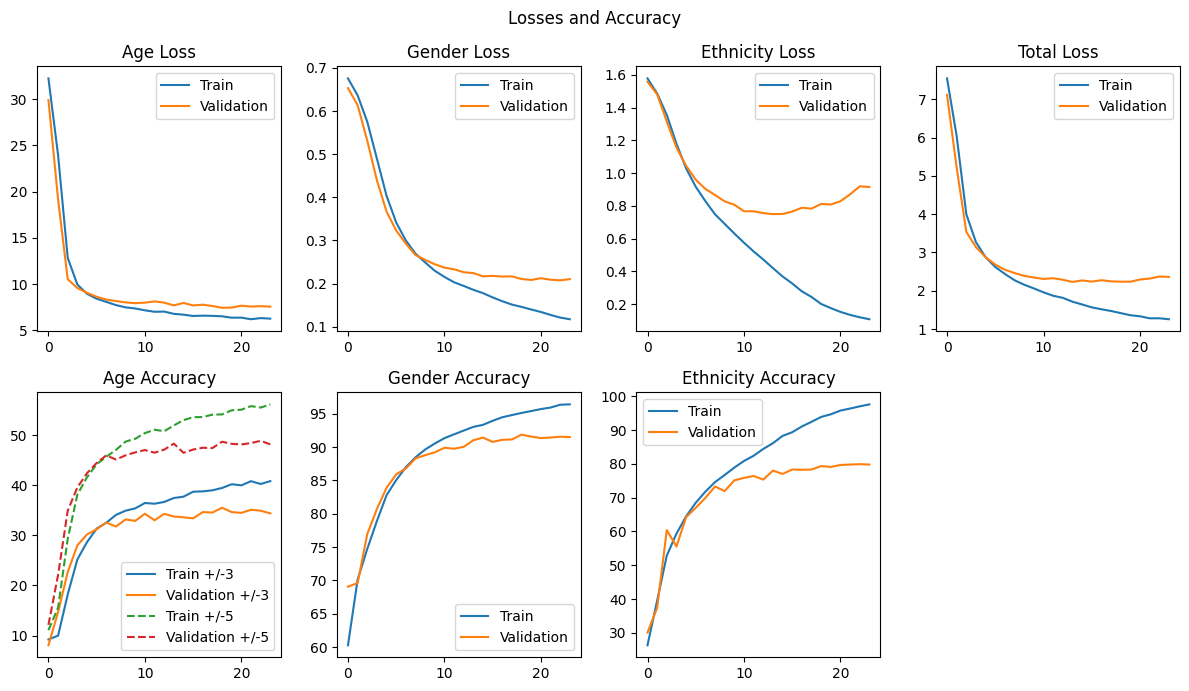

In [13]:
plotLossesAccuracy(losses, accuracy)

In [14]:
#model = torch.load(modelPath)
#model.eval()

In [15]:
#for name, param in resnetModel.named_parameters():
#    print(name, param.requires_grad)

In [16]:
def testNetwork(model, testLoader, device):
    model.eval()
    correctAge3, correctAge5, correctGender, correctEthnicity = 0, 0, 0, 0
    correctTest = 0
    totalTest = 0

    allAgePredictions = torch.tensor([], dtype=torch.float32).to(device)
    allGenderPredictions = torch.tensor([], dtype=torch.long).to(device)
    allEthnicityPredictions = torch.tensor([], dtype=torch.long).to(device)
    allAgeLabels = torch.tensor([], dtype=torch.float32).to(device)
    allGenderLabels = torch.tensor([], dtype=torch.long).to(device)
    allEthnicityLabels = torch.tensor([], dtype=torch.long).to(device)

    ### TESTING ###
    with torch.no_grad(): 
        for batch_nr, (images, labels) in enumerate(testLoader):
            # Move data to GPU (if exists)
            images, labels = images.to(device), labels.to(device)  

            ageLabels = labels[:, 0]
            genderLabels = labels[:, 1]
            ethnicityLabels = labels[:, 2]
            
            # Get predictions and get the amount of correct predicitons
            agePredictions, genderPredictions, ethnicityPredictions = model(images)

            agePredictions = torch.round(agePredictions).view(1, -1)
            correctAge3 += ((agePredictions - ageLabels).abs() <= 3).sum().item()
            correctAge5 += ((agePredictions - ageLabels).abs() <= 5).sum().item()

            _, genderPredictions = torch.max(genderPredictions, 1) 
            correctGender += (genderPredictions == genderLabels).sum().item() 

            _, ethnicityPredictions = torch.max(ethnicityPredictions, 1) 
            correctEthnicity += (ethnicityPredictions == ethnicityLabels).sum().item() 

            totalTest += len(images)
            
            # concatenate the predictions and labels of each batch
            allAgePredictions = torch.cat((allAgePredictions, agePredictions), dim=1)
            allGenderPredictions = torch.cat((allGenderPredictions, genderPredictions), dim=0)
            allEthnicityPredictions = torch.cat((allEthnicityPredictions, ethnicityPredictions), dim=0)
            allAgeLabels = torch.cat((allAgeLabels, ageLabels), dim=0)
            allGenderLabels = torch.cat((allGenderLabels, genderLabels), dim=0)
            allEthnicityLabels = torch.cat((allEthnicityLabels, ethnicityLabels), dim=0)

    age3Accuracy = 100 * correctAge3 / totalTest
    age5Accuracy = 100 * correctAge5 / totalTest
    genderAccuracy = 100 * correctGender / totalTest
    ethnicityAccuracy = 100 * correctEthnicity / totalTest

    print(f"Test Accuracy: (Age +/-3 years: {age3Accuracy:.2f}%, Age +/-5 years: {age5Accuracy:.2f}%, Gender: {genderAccuracy:.2f}%, Ethnicity: {ethnicityAccuracy:.2f}%)")
    return allAgePredictions, allGenderPredictions, allEthnicityPredictions, allAgeLabels, allGenderLabels, allEthnicityLabels

In [17]:
agePredictions, genderPredictions, ethnicityPredictions, ageLabels, genderLabels, ethnicityLabels = testNetwork(resnetModel, validLoader, device)

Test Accuracy: (Age +/-3 years: 43.04%, Age +/-5 years: 59.81%, Gender: 92.03%, Ethnicity: 80.39%)


In [18]:
agePredictions, ageLabels

(tensor([[63., 25., 79.,  ..., 57., 20., 52.]], device='cuda:0'),
 tensor([68., 26., 83.,  ..., 47., 17., 40.], device='cuda:0'))

In [19]:
ethnicityPredictions, ethnicityLabels

(tensor([0, 3, 0,  ..., 3, 1, 0], device='cuda:0'),
 tensor([0., 0., 0.,  ..., 3., 0., 0.], device='cuda:0'))

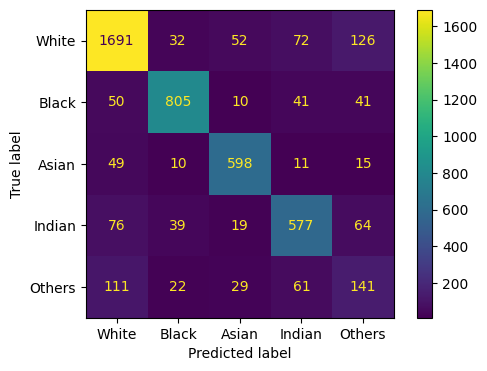

              precision    recall  f1-score   support

       White       0.86      0.86      0.86      1973
       Black       0.89      0.85      0.87       947
       Asian       0.84      0.88      0.86       683
      Indian       0.76      0.74      0.75       775
      Others       0.36      0.39      0.38       364

    accuracy                           0.80      4742
   macro avg       0.74      0.74      0.74      4742
weighted avg       0.81      0.80      0.80      4742



In [20]:
GENDER = ['M', 'F']
ETHNICITY = ['White', 'Black', 'Asian', 'Indian', 'Others']
# ETHNICITY = ['White', 'Black', 'Asian', 'Indian']
import pandas as pd
import sklearn.metrics as skmetric

matrix = skmetric.confusion_matrix(ethnicityLabels.cpu(), ethnicityPredictions.cpu())
display = skmetric.ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=ETHNICITY)
fig, ax = plt.subplots(figsize=(6,4))
display.plot(ax=ax)
plt.show()

print(skmetric.classification_report(ethnicityLabels.cpu(), ethnicityPredictions.cpu(), target_names = ETHNICITY))

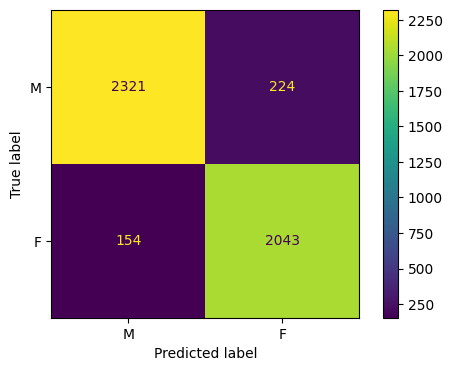

              precision    recall  f1-score   support

           M       0.94      0.91      0.92      2545
           F       0.90      0.93      0.92      2197

    accuracy                           0.92      4742
   macro avg       0.92      0.92      0.92      4742
weighted avg       0.92      0.92      0.92      4742



In [21]:
matrix = skmetric.confusion_matrix(genderLabels.cpu(), genderPredictions.cpu())
display = skmetric.ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=GENDER)
fig, ax = plt.subplots(figsize=(6,4))
display.plot(ax=ax)
plt.show()
print(skmetric.classification_report(genderLabels.cpu(), genderPredictions.cpu(), target_names = GENDER))

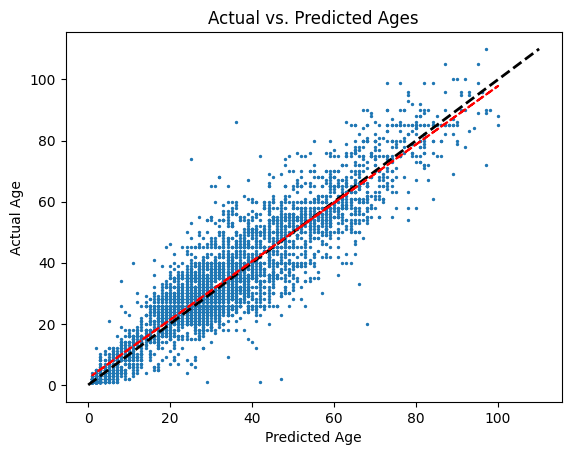

In [22]:
x, y = agePredictions.cpu()[0], ageLabels.cpu()
plt.scatter(x, y, s=2)
plt.plot([0, max(y)], [0, max(y)], 'k--', lw=2)

a, b = np.polyfit(x, y, 1)
plt.plot(x, a*x+b, 'r--')

plt.xlabel('Predicted Age')
plt.ylabel('Actual Age')
plt.title('Actual vs. Predicted Ages')
plt.show()

In [23]:
max(ageLabels.cpu()), min(ageLabels.cpu())

(tensor(110.), tensor(1.))

In [24]:
def testOwn(model, image_path, device, resize = 500):
    model.eval()

    # Define transforms
    transform = transforms.Compose([
        transforms.Resize(resize),
        transforms.CenterCrop(224),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # Load image and apply transforms
    image = torchvision.io.read_image(image_path).float()
    image = transform(image).unsqueeze(0)  # Add batch dimension

    with torch.no_grad():
        # Move data to GPU (if available)
        image = image.to(device)

        # Get predictions
        agePredictions, genderPredictions, ethnicityPredictions = model(image)

        agePrediction = torch.round(agePredictions).squeeze().item()
        genderPrediction = torch.argmax(genderPredictions).item()
        ethnicityPrediction = torch.argmax(ethnicityPredictions).item()

    # Create a grid of the image tensor
    image_grid = torchvision.utils.make_grid(image, normalize=True).cpu()

    # Plot the image
    plt.imshow(image_grid.permute(1, 2, 0))
    plt.axis('off')
    plt.show()

    print(f"Age: {agePrediction}, Gender: {GENDER[int(genderPrediction)]}, Ethnicity: {ETHNICITY[int(ethnicityPrediction)]}")


    return agePredictions, genderPredictions, ethnicityPredictions

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


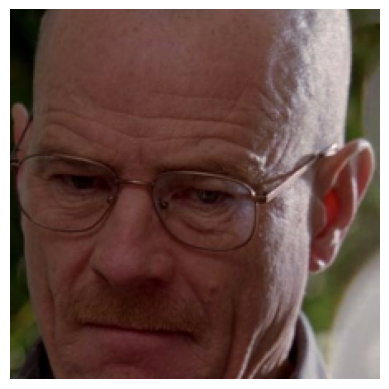

Age: 74.0, Gender: M, Ethnicity: White


(tensor([[74.4196]], device='cuda:0'),
 tensor([[0.9989, 0.0012]], device='cuda:0'),
 tensor([[ 6.4100, -1.5339, -0.9098, -4.0022, -2.7934]], device='cuda:0'))

In [25]:
image_path = "test.jpg"
testOwn(resnetModel, image_path, device, resize = 224)